In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from sklearn.externals import joblib
import MySQLdb as mdb

import sys 
sys.path.append('..')
from algo import generateHeader

In [41]:
con = mdb.connect(host="127.0.0.1", port=3310, user="root", passwd="bdd", db="canvas_fp_project")
cur = con.cursor(mdb.cursors.DictCursor)

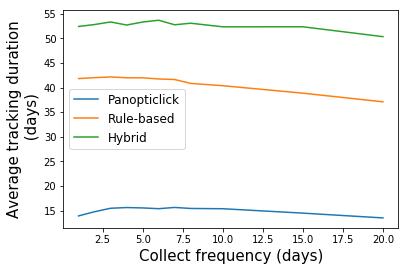

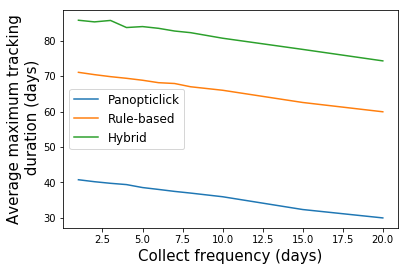

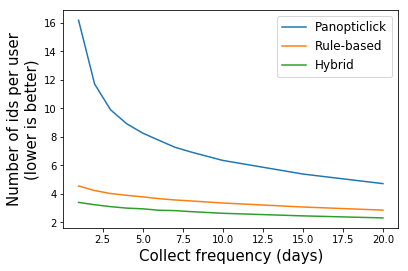

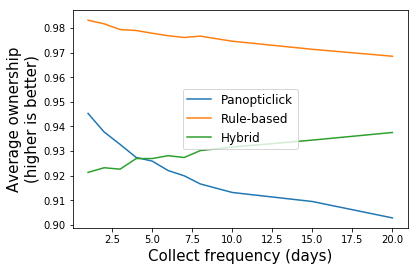

In [39]:
def process_results_replay(prefix_file):
    file_names = os.listdir("../results/")
    nb_days_to_tracking_time = dict()
    nb_days_to_nb_ids_assigned = dict()
    nb_days_to_nb_fps = dict()
    nb_days_to_max_chain_ratio = dict()
    nb_days_to_ownership = dict()
    nb_days_to_length_chain = dict()
    nb_days_to_nb_raw_days = dict()
    nb_days_to_acc = dict()
    nb_days_to_nb_ids_user = dict()
    for file_name in file_names:
        try:
            nb_days = file_name.split("_")[1]
            # special case for 0.5
            if "." in nb_days[:3]:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))/10.0
            else:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        except:
            nb_days = file_name.split("_")[2]
            nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        
        if prefix_file in file_name:
            df = pd.read_csv("../results/%s" % file_name)
            if "res1" in file_name:
                # we recompute ratio so that the first fingerprint of each assigned id is not counted
                df["ratio"] = (df["nb_original_fp"] - df["nb_assigned_ids"])/df["nb_assigned_ids"]
                df["nb_raw_days"] = df["ratio"] * nb_days
                df["nb_days"] = df["ratio"]/df["nb_original_fp"]
                df["max_chain_ratio"] = (df["max_chain"]-1)*nb_days
                df["acc"] = 1.0/df["nb_assigned_ids"]
                nb_days_to_tracking_time[nb_days] = np.mean(df["nb_days"])
                nb_days_to_max_chain_ratio[nb_days] = np.mean(df["max_chain_ratio"])
                nb_days_to_nb_raw_days[nb_days] = np.mean(df["nb_raw_days"])
                nb_days_to_acc[nb_days] = np.mean(df["acc"])
                nb_days_to_nb_ids_user[nb_days] = np.mean(df["nb_assigned_ids"])
            elif "res2" in file_name:
                nb_days_to_nb_ids_assigned[nb_days] = np.mean(df["nb_assigned_ids"])
                nb_days_to_ownership[nb_days] = np.mean(df["ownership"])
                nb_days_to_length_chain[nb_days] = np.mean(df["nb_fingerprints"])
            elif "replay" in file_name:
                nb_days_to_nb_fps[nb_days] = len(df)
    
    pandas_dict = {
        "nb_days": [],
        "nb_raw_days": [],
        "tracking_time": [],
        "nb_ids_assigned": [],
        "nb_fps": [],
        "max_chain_ratio": [],
        "length_chain": [],
        "ownership": [],
        "acc": [],
        "nb_days_to_nb_ids_user": []
        
    }
    
    for nb_days in nb_days_to_tracking_time:
        pandas_dict["nb_days"].append(nb_days)
        pandas_dict["tracking_time"].append(nb_days_to_tracking_time[nb_days])
        pandas_dict["nb_raw_days"].append(nb_days_to_nb_raw_days[nb_days])
        pandas_dict["nb_ids_assigned"].append(nb_days_to_nb_ids_assigned[nb_days])
        pandas_dict["nb_fps"].append(nb_days_to_nb_fps[nb_days])
        pandas_dict["max_chain_ratio"].append(nb_days_to_max_chain_ratio[nb_days])
        pandas_dict["length_chain"].append(nb_days_to_length_chain[nb_days])
        pandas_dict["ownership"].append(nb_days_to_ownership[nb_days])
        pandas_dict["acc"].append(nb_days_to_acc[nb_days])
        pandas_dict["nb_days_to_nb_ids_user"].append(nb_days_to_nb_ids_user[nb_days])
#         print(nb_days, nb_days_to_tracking_time[nb_days], nb_days_to_nb_ids_assigned[nb_days],
#               nb_days_to_nb_fps[nb_days], nb_days_to_max_chain_ratio[nb_days],
#               nb_days_to_length_chain[nb_days], nb_days_to_ownership[nb_days])
    return pd.DataFrame(pandas_dict).sort_values("nb_days")
        

avg_presence_time = 109 #days
# replace with eckersley
df_eck = process_results_replay("eck")
# df_eck = process_results_replay("nov9", "eck")

x_eck = df_eck["nb_days"]
y_eck = df_eck["nb_raw_days"]


df_rule = process_results_replay("rule")
# df_rule = process_results_replay("nov9", "rule")

x_rule = df_rule["nb_days"]
y_rule = df_rule["nb_raw_days"]

# df_ml = process_results_replay("thesis-model-ml")
# df_ml = process_results_replay("newfeaturesml")
df_ml = process_results_replay("mlv1thesis")
x_ml = df_ml["nb_days"]
y_ml = df_ml["nb_raw_days"]

line1_eck, = plt.plot(x_eck, y_eck, label="Panopticlick")
line1_rules, = plt.plot(x_rule, y_rule, label="Rule-based")
line1_ml, = plt.plot(x_ml, y_ml, label="Hybrid")
plt.ylabel('Average tracking duration\n (days)', fontsize=15)
plt.xlabel('Collect frequency (days)', fontsize=15)
plt.legend(handles=[line1_eck, line1_rules, line1_ml], loc=0, fontsize=12)
plt.savefig('./raw_days_frequency.pdf', bbox_inches = 'tight')
plt.show()
plt.show()

y_eck_max_time = df_eck["max_chain_ratio"]
y_rule_max_time = df_rule["max_chain_ratio"]
y_ml_max_time = df_ml["max_chain_ratio"]

line2_eck, = plt.plot(x_eck, y_eck_max_time, label="Panopticlick")
line2_rules, = plt.plot(x_rule, y_rule_max_time, label="Rule-based")
line2_ml, = plt.plot(x_ml, y_ml_max_time, label="Hybrid")
plt.legend(handles=[line2_eck, line2_rules, line2_ml], loc=0, fontsize=12)
plt.ylabel('Average maximum tracking\n duration (days)', fontsize=15)
plt.xlabel('Collect frequency (days)', fontsize=15)

plt.savefig('./raw_max_days_frequency.pdf', bbox_inches = 'tight')
plt.show()


y_eck_ids = df_eck["nb_days_to_nb_ids_user"]
y_rule_ids = df_rule["nb_days_to_nb_ids_user"]
y_ml_ids = df_ml["nb_days_to_nb_ids_user"]

line3_eck, = plt.plot(x_eck, y_eck_ids, label="Panopticlick")
line3_rule, = plt.plot(x_rule, y_rule_ids, label="Rule-based")
line3_ml, = plt.plot(x_ml, y_ml_ids, label="Hybrid")
plt.legend(handles=[line3_eck, line3_rule, line3_ml], loc=0, fontsize=12)
plt.ylabel('Number of ids per user\n(lower is better)', fontsize=15)
plt.xlabel('Collect frequency (days)', fontsize=15)
plt.savefig('./nb_ids_frequency.pdf', bbox_inches = 'tight')
plt.show()


y_eck_own = df_eck["ownership"]
y_rule_own = df_rule["ownership"]
y_ml_own = df_ml["ownership"]

line4_eck, = plt.plot(x_eck, y_eck_own, label="Panopticlick")
line4_rule, = plt.plot(x_rule, y_rule_own, label="Rule-based")
line4_ml, = plt.plot(x_ml, y_ml_own, label="Hybrid")
plt.ylabel('Average ownership\n(higher is better)', fontsize=15)
plt.xlabel('Collect frequency (days)', fontsize=15)
plt.legend(handles=[line4_eck, line4_rule, line4_ml], loc=0, fontsize=12)
plt.savefig('./ownership_frequency.pdf', bbox_inches = 'tight')
plt.show()


1.0 1724
2.0 1724
3.0 1724
4.0 1724
5.0 1724
6.0 1724
7.0 1724
8.0 1724
10.0 1724
15.0 1724
20.0 1724
1724
1724
1747
15      315.0
25      315.0
46      308.0
117     308.0
308     308.0
275     308.0
274     308.0
276     301.0
311     301.0
62      301.0
266     301.0
317     301.0
383     301.0
146     294.0
468     294.0
457     287.0
459     287.0
280     280.0
115     273.0
634     273.0
382     273.0
334     273.0
492     266.0
375     266.0
661     259.0
698     259.0
307     252.0
825     245.0
168     245.0
622     238.0
        ...  
368       0.0
388       0.0
1664      0.0
1075      0.0
1080      0.0
76        0.0
1083      0.0
1114      0.0
1116      0.0
601       0.0
1117      0.0
602       0.0
371       0.0
1121      0.0
1129      0.0
778       0.0
1635      0.0
1485      0.0
1164      0.0
1628      0.0
1627      0.0
819       0.0
1174      0.0
809       0.0
114       0.0
1182      0.0
483       0.0
1196      0.0
324       0.0
1723      0.0
Name: nb_raw_days, Length: 17

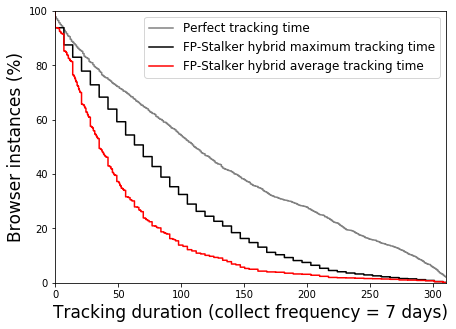

6.0


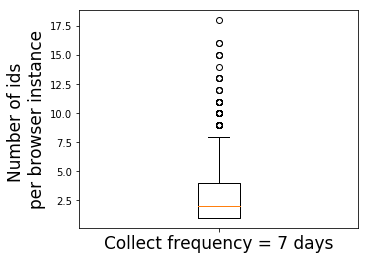

1.0


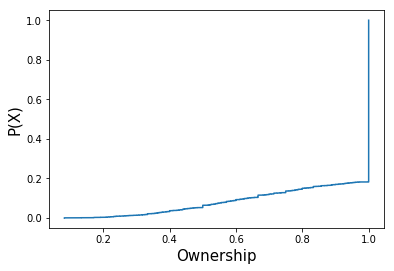

In [47]:
def get_results_details(prefix_file):
    file_names = os.listdir("../results/")
    nb_days_to_df1 = dict()
    nb_days_to_df2 = dict()
    for file_name in file_names:
        try:
            nb_days = file_name.split("_")[1]
            # special case for 0.5
            if "." in nb_days[:3]:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))/10.0
            else:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        except:
            nb_days = file_name.split("_")[2]
            nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        
        if prefix_file in file_name:
            df = pd.read_csv("../results/%s" % file_name)
            if "res1" in file_name:
                print(nb_days, len(df))
                # we recompute ratio so that the first fingerprint of each assigned id is not counted
                df["ratio"] = (df["nb_original_fp"] - df["nb_assigned_ids"])/df["nb_assigned_ids"]
                df["nb_raw_days"] = df["ratio"] * nb_days
                df["nb_days"] = df["ratio"]/df["nb_original_fp"]
                df["max_chain_ratio"] = (df["max_chain"]-1)*nb_days
                df["acc"] = 1.0/df["nb_assigned_ids"]
                nb_days_to_df1[nb_days] = df
            elif "res2" in file_name:
                nb_days_to_df2[nb_days] = df

    return nb_days_to_df1, nb_days_to_df2


nb_days_to_df1, nb_days_to_df2 = get_results_details("mlv1thesis")

df_7 = nb_days_to_df1[7]

# we plot ground truth on same graph

with open("../data/consistent_extension_ids.csv", "r") as f:
    # we jump header
    f.readline()
    ids_query = []

    for line in f.readlines():
        ids_query.append("'" + line.replace("\n", "") + "'")
    
ids_query = ",".join(ids_query)

#172781
# check if 7 or 6
cur.execute("SELECT creationDate, id FROM extensionData WHERE counter < 199910 and \
                id in ("+ids_query+") and \
                id in (SELECT id FROM extensionData GROUP BY \
                id having count(*) > 6)\
                ORDER by counter ASC")

fps = cur.fetchall()
index_split = int(len(fps)*0.4)
# train, test
fps = fps[index_split:]

user_id_to_fps = {}

for fp in fps:
    try:
        user_id_to_fps[fp["id"]].append(fp["creationDate"])
    except:
        user_id_to_fps[fp["id"]] = [fp["creationDate"]]


durations = []
p = []
current_p = 100

for user_id in user_id_to_fps:
    fps = user_id_to_fps[user_id]
    duration_user = (fps[-1] - fps[0]).days
    durations.append(duration_user)
    p.append(current_p)
    current_p -= 100.0/(len(user_id_to_fps))


durations.sort(reverse=False)
plt.figure(figsize=(7, 5))
lref, = plt.plot(durations, p, label="Perfect tracking time", color="gray")

data = df_7["max_chain_ratio"].sort_values(ascending=False)
data2 = df_7["nb_raw_days"].sort_values(ascending=False)

cum_dist = np.linspace(0.,100.0,len(data))
ser_cdf = pd.Series(cum_dist, index=data)
ser_cdf2 = pd.Series(cum_dist, index=data2)
plt.ylabel('Browser instances (%)', fontsize=17)
plt.xlabel('Tracking duration (collect frequency = 7 days)', fontsize=17)
plt.xlim([0, 310])
plt.ylim([0, 100])
line_ser, = plt.plot(ser_cdf, drawstyle='steps', label="FP-Stalker hybrid maximum tracking time", color="black")
line_ser2, = plt.plot(ser_cdf2, drawstyle='steps', label="FP-Stalker hybrid average tracking time", color="red")
plt.legend(handles=[lref, line_ser, line_ser2], loc=0, fontsize=12)

# print(len(ser_cdf))
# print(len(ser_cdf2))
# print(len(durations))

with open('durations.csv', 'w+') as f:
    f.write("duration,p\n")
    for idx in range(len(durations)):
        f.write("{:f},{:f}\n".format(durations[idx], p[idx]))
# with open('./cdf_tracking_time.csv', "w+") as f:
    

# plt.savefig('./cdf_tracking_time.pdf', bbox_inches = 'tight')
plt.savefig('./cdf_tracking_time_inverse.pdf', bbox_inches = 'tight')

plt.show()

data_ids = df_7["nb_assigned_ids"].sort_values()
print(np.percentile(data_ids, 90))
cum_dist = np.linspace(0.,1.,len(data_ids))
ser_cdf_ids = pd.Series(cum_dist, index=data_ids)
plt.figure(figsize=(5, 4))
plt.ylabel('Number of ids \nper browser instance', fontsize=17)
plt.boxplot(data_ids)
plt.xticks([1], ['Collect frequency = 7 days'], fontsize=17)
plt.savefig('./boxplot_nb_ids.pdf', bbox_inches = 'tight')
plt.show()


df2_7 = nb_days_to_df2[7]
data_ownership = df2_7["ownership"].sort_values()
print(np.percentile(data_ownership, 90))
cum_dist2 = np.linspace(0.,1.,len(data_ownership))
ser_cdf_ownership = pd.Series(cum_dist2, index=data_ownership)
plt.ylabel('P(X)', fontsize=15)
plt.xlabel('Ownership', fontsize=15)
plt.plot(ser_cdf_ownership, drawstyle='steps')
plt.savefig('./cdf_ownership.pdf')
plt.show()

11
11
11
Feature ranking:
1. feature nbChange (0.323862)
2. feature creationDate (0.224774)
3. feature userAgentHttp (0.193886)
4. feature languageHttp (0.118037)
5. feature simPlugs (0.093878)
6. feature canvasJSHashed (0.020307)
7. feature rendererWebGLJS (0.018331)
8. feature resolutionJS (0.003615)
9. feature timezoneJS (0.002294)
10. feature sameFonts (0.000685)
11. feature hasFlash (0.000330)


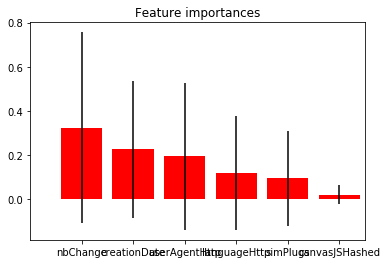

In [66]:
header = ['canvasJSHashed', 'creationDate', 'hasFlash', 'sameFonts', 'languageHttp', 'simPlugs', 'rendererWebGLJS', 'resolutionJS', 'timezoneJS', 'userAgentHttp', 'nbChange']
model = joblib.load("../data/my_ml_model")
importances = model.feature_importances_
print(len(model.estimators_[0].feature_importances_))
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(len(indices))
print(len(header))

name_attributes = header

# Print the feature ranking
print("Feature ranking:")
for f in range(len(name_attributes)):
    print("%d. feature %s (%f)" % (f + 1, name_attributes[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(name_attributes)), importances[indices],
       color="r", yerr=std[indices], align="center")
labels_to_keep = [name_attributes[x] for x in indices]
plt.xticks(range(len(name_attributes)), labels_to_keep)
plt.xlim([-1, 5.5])
plt.show()